# Cryosphere model Comparison tool (CmCt) --- Gravimetry

The CmCt GRACE mascon tool compares user uploaded ice sheet model to satellite gravimetry in the form of mascon data, derived from the GRACE and GRACE-FO satellite missions. The CmCt reprojects modeled ice sheet mass change into mascon space and performs a direct quantitative comparison, calculating model-observation discrepancies, therefore bringing the ice sheet model and gravimetry data to the same spatial resolution for comparison. 

## Mascon dataset description

For comparison to the user's model, the tool currently uses the `GSFC.glb.200204_202312_RL06v2.0_OBP-ICE6GD` GRACE mascon product from 04/2002 to 12/2023 that can be requested at the NASA GSFC dataset [main distribution site](https://earth.gsfc.nasa.gov/geo/data/grace-mascons/). Future developments will include adding the functionality to automatically check the product distribution website for an updated dataset.

## Input data requirements

The input ice sheet model needs to be provided as a netCDF file. The user may upload a single input file that includes multiple years; future enhancements to this tool will allow users to upload model ensembles.

There are several requirements for the comparison:

### `Lithk` variable

The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison.

### Rectangular grid

At time of writing, models *must* be defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. (Note, NOT a lat-lon grid!) The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki). 

### Date range

The gravimetry data spans 04/2002 to 12/2023. The user can select start and end dates within this span as part of the setup for the tool.

## Tool output

from gravimetry_utils import *This tool creates a plot that GRACE mascon plot and the model mascon plot so the user can  qualitatively compare the model output with the observational data. 

In [1]:
## Import modules
import os,sys
import glob as glob
import numpy as np
import h5py
import xarray as xr
import glob as glob

import datetime

# Add the directory containing 'mascons.py' to the Python path
# Get the current working directory
current_directory = os.getcwd()
# Navigate two levels up to reach main dir
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir, os.pardir))
# Insert the specific directory into the system path
sys.path.insert(0, os.path.join(parent_directory, 'bin', 'Gravimetry'))
# Now import mascons
import mascons
from gravimetry_utils import *

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))


# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

## Configure gravimetry comparison

In [2]:
# Ice sheet
loc='GIS' # 'GIS' or 'AIS'

# Set time range for comparison
start_date = '2005-01-01' 
end_date = '2014-12-31' 

#Set the observation data dir path
obs_filename='/home/jovyan/CmCt/data/Gravimetry/gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd.h5'

#Set the shape data dir path
shape_filename='/home/jovyan/CmCt/data/ne_10m_coastline/ne_10m_coastline.shp'

#Set the model data dir path
if loc == "GIS":
    #Greenland
    nc_filename='/home/jovyan/shared-public/CmCt/models/ISMIP6/lithk_GIS_IMAU_IMAUICE1_historical.nc'
elif loc == "AIS":    
    #Antartica
    nc_filename='/home/jovyan/CmCt/notebooks/Gravimetry/lithk_AIS_AWI_PISM1_hist_std.nc'


#Set the output plot file names
plot_filename = os.path.splitext(os.path.basename(nc_filename))[0] + '_mascon_comp'
output_plot_filename='/home/jovyan/CmCt/notebooks/Gravimetry/'+ plot_filename + '.png'
output_netcdf_filename='/home/jovyan/CmCt/notebooks/Gravimetry/'+ plot_filename + '.nc'

In [3]:
# Check if observation file exist
if not os.path.exists(obs_filename):
    raise FileNotFoundError(f"Observation file not found: {obs_filename}")

# Check if model file exist    
if not os.path.exists(nc_filename):
    raise FileNotFoundError(f"Model file not found: {nc_filename}")

## Set polar sterographic projection definition
Currently, the CmCt expects the model data to be provided in a specific polar stereographic projection. This is hardcoded in the notebook. As a future enhancement, the projection can be obtained from the loaded model.

In [4]:
polar_stereographic=set_projection(loc)

## Process observation

In [5]:
# Load observation data(mascons)
gsfc = loadGsfcMascons(obs_filename)

# Compute the mascon means and calulate mass change of observation data
mass_change_obs,I_ = computeMasconMeans(gsfc, start_date, end_date,loc)

## Process ice sheet model

In [6]:
# Load model data
gis_ds = loadGisModel(nc_filename)

# Put model into mascon space and calulate mass change of model data
try:
    mass_change_mod_trim, mass_change_mod = transformToGeodetic(gsfc, gis_ds, start_date, end_date,polar_stereographic)
except Exception as error:
    print('Error: model transform to geodetic failed. Terminating calculation.')
    print(error)

Data successfully written to /home/jovyan/CmCt/notebooks/Gravimetry/lithk_GIS_IMAU_IMAUICE1_historical_mascon_comp.nc


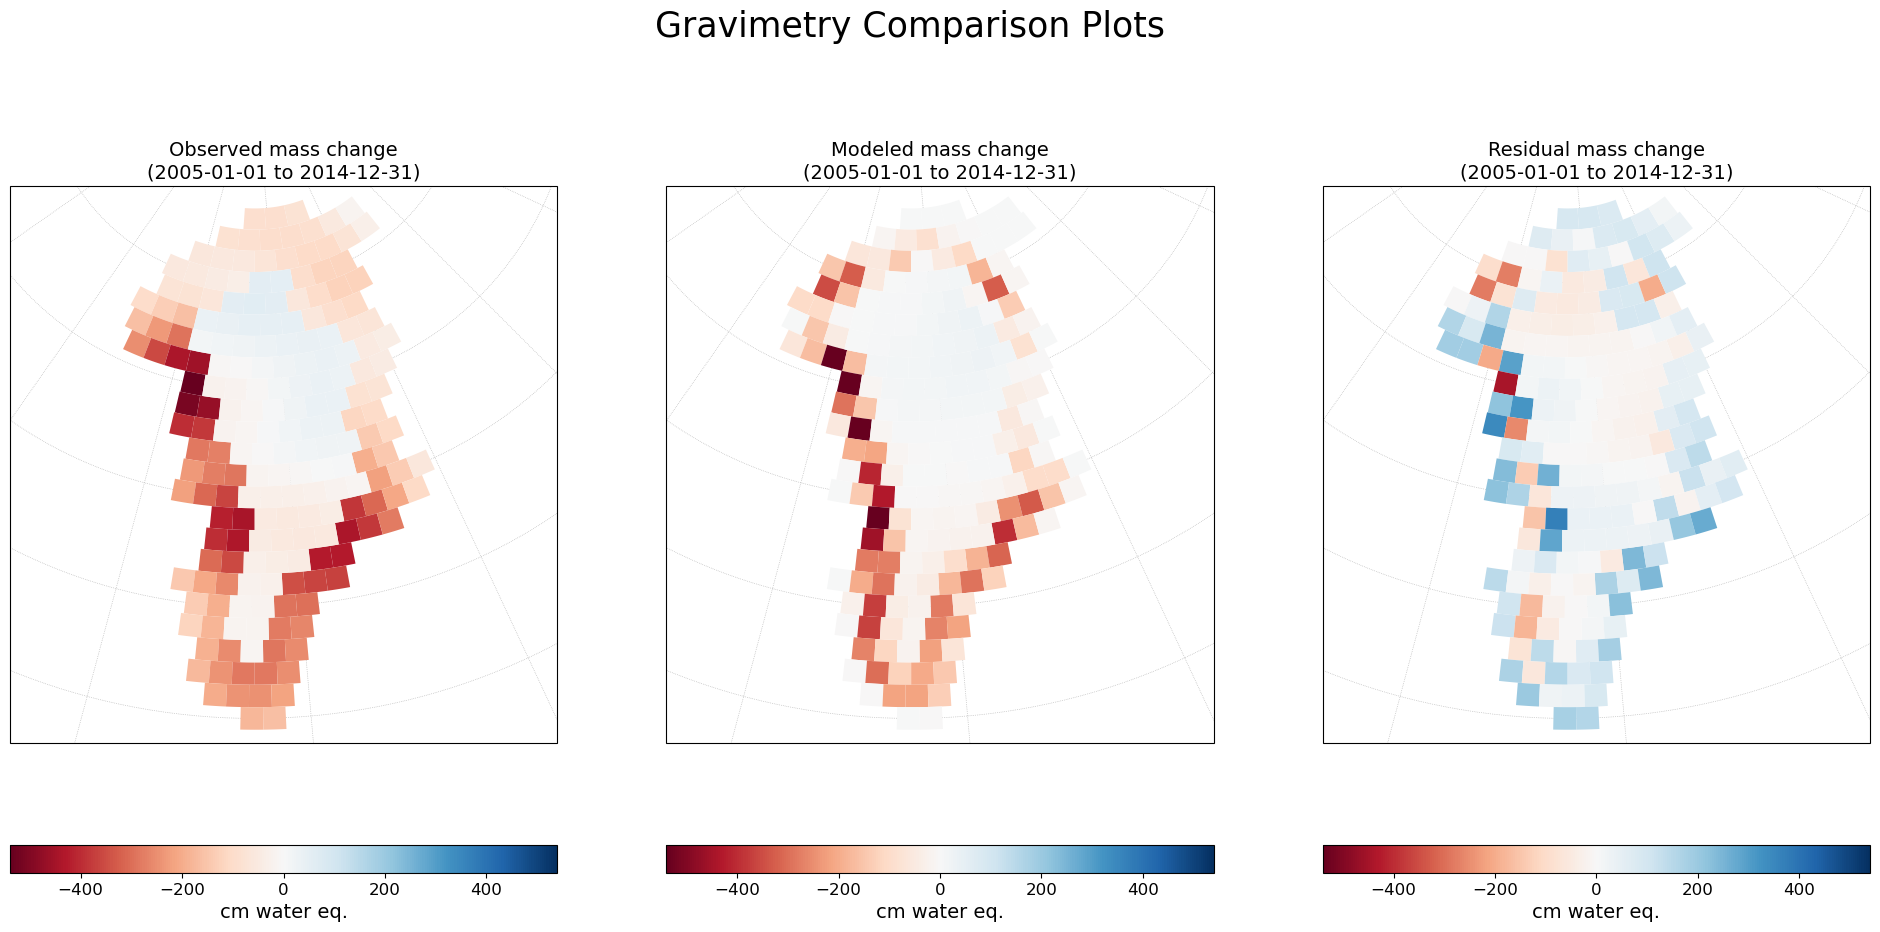

In [7]:
# Calculate mass change of model and observation data
try:
    mass_change_delta=mass_change_mod_trim-mass_change_obs
except Exception as error:
    print('Error: Calculation failed.')
    print(error)

# Write result to nc file
write_to_netcdf(mass_change_obs, mass_change_delta, mass_change_mod,gsfc, start_date, end_date, output_netcdf_filename)

# Plot results
try:
    plotFigure(mass_change_obs, mass_change_mod_trim, mass_change_delta, gsfc, I_,start_date, end_date,polar_stereographic,loc,shape_filename,output_plot_filename)
except Exception as error:
    print('Error: plotting failed.')
    print(error)